# ChromVAR Expression Heatmaps

Visualization of ChromVAR and expression of correlated factors along trajectories. Developed on top of the `20201025_trajectory_viz/TrajViz.ipynb` notebook.

Inputs:
1. ATAC metadata
2. ATAC pseudotime
3. ATAC ChromVAR
4. ArchR Gene Score
5. RNA Seurat object
6. RNA clusters (transfered from ATAC)
7. CCA or similar coembedding coordinates for ATAC+RNA
8. Cluster and Day configs
9. Motif group metadata (e.g. Vierstra motif clusters) 

In [1]:
library(Seurat)
library(ArchR)
library(RANN)
library(patchwork)
library(mgcv) # for smoothing

Loading required package: ggplot2

Loading required package: SummarizedExperiment

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    unio

In [2]:
DAYS = c("D0", "D2", "D4", "D6", "D8", "D10", "D12", "D14")

In [3]:
addArchRThreads(threads = 32) 

Setting default number of Parallel threads to 32.



In [4]:
addArchRGenome("hg38")

Setting default genome to Hg38.



## Load Inputs

### ATAC MetaData

In [5]:
# should contain, sample_barcode as rowname, sample, umap1, umap2, cluster
metaData = read.table("../../analysis/20200206_pmat_snapATAC/sessions/20201022_n53906/metadata.tsv", header = T)
rownames(metaData) = paste(metaData$sample, metaData$barcode, sep='_')
metaData$cells = rownames(metaData) # for cicero
metaData$sample = factor(metaData$sample, levels=DAYS)
dim(metaData)
head(metaData, 5)

[1] 53906     6

barcode          sample umap1    umap2     cluster
D0_AACGCGAGAAGGACCA AACGCGAGAAGGACCA D0     8.373301 -4.292619 5      
D0_AACGCGCTGTCTGTGA AACGCGCTGTCTGTGA D0     2.033609 -7.860645 5      
D0_ACCTATGGACTCGATA ACCTATGGACTCGATA D0     3.093788 -7.469210 5      
D0_ACGCAGAGATAACCCA ACGCAGAGATAACCCA D0     6.001364 -7.523576 5      
D0_ACTCGCTACTTGTGAC ACTCGCTACTTGTGAC D0     3.343237 -8.114589 5      
                    cells              
D0_AACGCGAGAAGGACCA D0_AACGCGAGAAGGACCA
D0_AACGCGCTGTCTGTGA D0_AACGCGCTGTCTGTGA
D0_ACCTATGGACTCGATA D0_ACCTATGGACTCGATA
D0_ACGCAGAGATAACCCA D0_ACGCAGAGATAACCCA
D0_ACTCGCTACTTGTGAC D0_ACTCGCTACTTGTGAC

### Cluster Config

In [6]:
cluster_config = read.table("../configs/cluster.tsv", comment.char = '', sep='\t', header=T)
cluster_config

cluster colour  description            new_cluster
1   1      #A6D854 Pre-iPSC               14         
2   2      #F0A118 Intermediate           12         
3   3      #E85F6D Fibroblast-like         3         
4   4      #006658 Neural-like             8         
5   5      #B03743 Fibroblast              1         
6   6      #CF175A Fibroblast-like         4         
7   7      #78A824 Pre-iPSC               13         
8   8      #F4D5CD Intermediate           11         
9   9      #D4B81C Intermediate            9         
10 10      #F01D35 Fibroblast-like         5         
11 11      #7C2730 Fibroblast-like         2         
12 12      #F7A6C2 Keratinocyte-like       6         
13 13      #406614 Partially-reprogrammed 10         
14 14      #F0520A Early intermediate      7

In [7]:
metaData$cluster_new_id = cluster_config[metaData$cluster, "new_cluster"]

### Day Config

In [8]:
day_config = read.table("../configs/day.tsv", 
                        comment.char = '', 
                        sep='\t', 
                        header=T,
                       stringsAsFactor=F)
rownames(day_config) = day_config$day
day_config

day colour 
D0  D0  #A61C24
D2  D2  #FF70A6
D4  D4  #D6E82F
D6  D6  #B14AED
D8  D8  #2D3142
D10 D10 #FC7753
D12 D12 #0AABB7
D14 D14 #336699

### ArchR Gene Score

In [9]:
ArrowFiles = c('D0.arrow',
               'D2.arrow',
               'D4.arrow',
               'D6.arrow',
               'D8.arrow',
               'D10.arrow',
               'D12.arrow',
               'D14.arrow')
#              'H1.arrow')

In [10]:
archr_proj <- ArchRProject(
  ArrowFiles = paste("/srv/scratch/surag/scATAC-reprog/arrow/", ArrowFiles, sep=''), 
  outputDirectory = "./tmp/",
  copyArrows = FALSE #This is recommened so that you maintain an unaltered copy for later usage.
)

Using GeneAnnotation set by addArchRGenome(Hg38)!

Using GeneAnnotation set by addArchRGenome(Hg38)!

Validating Arrows...

Getting SampleNames...



Getting Cell Metadata...



Merging Cell Metadata...

Initializing ArchRProject...


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,-

In [11]:
all(paste(metaData$sample, metaData$barcode, sep='#') %in% archr_proj$cellNames)

[1] TRUE

In [12]:
# subset to cells
archr_proj = archr_proj[paste(metaData$sample, metaData$barcode, sep='#'), ]

In [13]:
getAvailableMatrices(archr_proj)

[1] "GeneIntegrationMatrix" "GeneScoreMatrix"       "PeakMatrix"           
[4] "TileMatrix"

In [14]:
archr_gene_score = getMatrixFromProject(archr_proj, "GeneScoreMatrix")
dim(archr_gene_score)

ArchR logging to : ArchRLogs/ArchR-getMatrixFromProject-df9b1817f956-Date-2020-11-23_Time-04-52-37.log
If there is an issue, please report to github with logFile!

2020-11-23 04:54:23 : Organizing colData, 1.764 mins elapsed.

2020-11-23 04:54:23 : Organizing rowData, 1.766 mins elapsed.

2020-11-23 04:54:23 : Organizing Assays (1 of 1), 1.766 mins elapsed.

2020-11-23 04:55:31 : Constructing SummarizedExperiment, 2.899 mins elapsed.

2020-11-23 04:55:33 : Finished Matrix Creation, 2.926 mins elapsed.



[1] 24919 53906

In [15]:
archr_gene_score_mat = archr_gene_score@assays@data$GeneScoreMatrix
rownames(archr_gene_score_mat) = rowData(archr_gene_score)$name
colnames(archr_gene_score_mat) = sub("#", "_", rownames(colData(archr_gene_score)))
# reorder
archr_gene_score_mat = archr_gene_score_mat[, rownames(metaData)]

In [16]:
sum(is.na(archr_gene_score_mat))

[1] 0

In [17]:
# reclaim some memory
rm(archr_gene_score)
gc()

used      (Mb)   gc trigger (Mb)    max used   (Mb)   
Ncells   7895107  421.7   11519074   615.2   10218569   545.8
Vcells 649477256 4955.2 2130974985 16258.1 2201659236 16797.4

### Seurat Object

In [18]:
rna = readRDS("../../analysis/20200828_RNA_Seurat/sessions/20200913_n59369/seurat.rds")
rna$tech = "rna"

### ATAC-RNA Label Transfer

In [19]:
atac.rna.label = read.table("../../analysis/20200828_RNA_Seurat/sessions/20200913_n59369/atac.20201022_n53906.cluster.transfer.tsv",
                           header=T)
rownames(atac.rna.label) = atac.rna.label$barcode
atac.rna.label$barcode = NULL

all(rownames(atac.rna.label)==colnames(rna))

# transfer to new cluster
atac.rna.label$atac_new_cluster = cluster_config[atac.rna.label$atac_cluster, "new_cluster"]

head(atac.rna.label)

[1] TRUE

sample atac_cluster atac_new_cluster
AAACCCAAGAGTGACC-1 D0     5            1               
AAACCCAAGTGCCAGA-1 D0     5            1               
AAACCCACACCATTCC-1 D0     5            1               
AAACCCACACGCGTCA-1 D0     5            1               
AAACCCAGTCCATAGT-1 D0     5            1               
AAACCCAGTTATTCTC-1 D0     5            1

### ATAC Pseudotime

In [20]:
pseudotime = read.table("../../analysis/20200217_trajectory/sessions/20201022_n53906/pseudotime.tsv")
rownames(pseudotime) = pseudotime$sample_barcode
pseudotime$sample_barcode = NULL
all(rownames(pseudotime) == rownames(metaData))
head(pseudotime)

[1] TRUE

dpt_pseudotime
D0_AACGCGAGAAGGACCA 0.00000000    
D0_AACGCGCTGTCTGTGA 0.20646924    
D0_ACCTATGGACTCGATA 0.17054172    
D0_ACGCAGAGATAACCCA 0.09116346    
D0_ACTCGCTACTTGTGAC 0.16613631    
D0_AGACTACTGGCAGTTT 0.05593833

### ChromVAR Scores

In [21]:
# Load ChromVAR (needs to be updated)
chromvar = read.table(gzfile("../../analysis/20200607_ChromVAR/out/20201020_n62402/20201119_bpnet.no_iPSC.FDR_0.1_hits.tsv"),
                            check.names=FALSE, # keeps + in FOS+JUN instead of converting to FOS.JUN
                      sep='\t')
all(rownames(metaData) %in% rownames(chromvar))
chromvar = chromvar[rownames(metaData),] 
head(chromvar)

[1] TRUE

AP2A_HUMAN.H11MO.0.A AP2A_MOUSE.H11MO.0.A
D0_AACGCGAGAAGGACCA -0.12294065          -0.09352625         
D0_AACGCGCTGTCTGTGA -0.12821733          -0.09127279         
D0_ACCTATGGACTCGATA -0.09000103          -0.07525123         
D0_ACGCAGAGATAACCCA -0.13996900          -0.11293790         
D0_ACTCGCTACTTGTGAC -0.29016466          -0.26960139         
D0_AGACTACTGGCAGTTT -0.05789882          -0.03753335         
                    AP2C_HUMAN.H11MO.0.A Ascl2.mouse_bHLH_1
D0_AACGCGAGAAGGACCA -0.10794921           0.08798450       
D0_AACGCGCTGTCTGTGA -0.11971037          -0.05039826       
D0_ACCTATGGACTCGATA -0.05044384           0.02199156       
D0_ACGCAGAGATAACCCA -0.12036074           0.03213452       
D0_ACTCGCTACTTGTGAC -0.26274589          -0.08115598       
D0_AGACTACTGGCAGTTT -0.03960972           0.07398756       
                    ATF1_MOUSE.H11MO.0.B BATF+JUN_MA0462.1 CEBPA_MA0102.3
D0_AACGCGAGAAGGACCA  0.018353336         0.03361392         0.34264057   
D0_AACGCGCTGTCTGTGA -0.165470322         0.17952061        -0.06281021   
D0_ACCTATGGACTCGATA  0.064826831         0.16002619         0.17504433   
D0_ACGCAGAGATAACCCA  0.007410609         0.10376001         0.06106466   
D0_ACTCGCTACTTGTGAC  0.169576565         0.17302266         0.05314971   
D0_AGACTACTGGCAGTTT  0.126405154         0.12559693         0.39322449   
                    CEBPB_MOUSE.H11MO.0.A CREB1_MA0018.3 CREB3_bZIP_1 ⋯
D0_AACGCGAGAAGGACCA  0.22410861            0.12877157     0.10686871  ⋯
D0_AACGCGCTGTCTGTGA -0.08282114            0.12301088     0.12257224  ⋯
D0_ACCTATGGACTCGATA  0.16178425           -0.01575793    -0.04535254  ⋯
D0_ACGCAGAGATAACCCA  0.04992117            0.10107298     0.08227665  ⋯
D0_ACTCGCTACTTGTGAC  0.21316328            0.08961263     0.11566191  ⋯
D0_AGACTACTGGCAGTTT  0.30191576            0.07435968     0.10389412  ⋯
                    VEZF1_HUMAN.H11MO.0.C YY1_MA0095.2 ZBTB18_MA0698.1
D0_AACGCGAGAAGGACCA -0.05705881           -0.035062317  0.0654240384  
D0_AACGCGCTGTCTGTGA -0.05607968           -0.068237933 -0.0634596941  
D0_ACCTATGGACTCGATA -0.04363534           -0.032693962  0.0083265061  
D0_ACGCAGAGATAACCCA -0.06270160           -0.157120673  0.0279788745  
D0_ACTCGCTACTTGTGAC -0.11856937            0.002780547 -0.2417367283  
D0_AGACTACTGGCAGTTT -0.02603083           -0.093000115  0.0005260283  
                    ZBTB33_MA0527.1 ZFX_MOUSE.H11MO.0.B ZN143_HUMAN.H11MO.0.A
D0_AACGCGAGAAGGACCA -0.003564588    -0.03832660         -0.03587245          
D0_AACGCGCTGTCTGTGA  0.032931037    -0.04811726         -0.02580824          
D0_ACCTATGGACTCGATA -0.079405863    -0.01814928         -0.03548759          
D0_ACGCAGAGATAACCCA -0.047696751    -0.04599367         -0.09518446          
D0_ACTCGCTACTTGTGAC  0.138115475    -0.13441524         -0.10250958          
D0_AGACTACTGGCAGTTT -0.059059651    -0.01943282         -0.04448186          
                    ZN143_MOUSE.H11MO.0.A ZNF238_C2H2_1 ZNF238_C2H2_2
D0_AACGCGAGAAGGACCA -0.03941892            0.04882215    0.0654240384
D0_AACGCGCTGTCTGTGA -0.02821128           -0.04213231   -0.0634596941
D0_ACCTATGGACTCGATA -0.01061891            0.03299011    0.0083265061
D0_ACGCAGAGATAACCCA -0.09121124            0.05588418    0.0279788745
D0_ACTCGCTACTTGTGAC -0.17400573           -0.25518424   -0.2417367283
D0_AGACTACTGGCAGTTT -0.02886792            0.02527477    0.0005260283
                    ZNF76_HUMAN.H11MO.0.C
D0_AACGCGAGAAGGACCA -0.06306453          
D0_AACGCGCTGTCTGTGA -0.06673984          
D0_ACCTATGGACTCGATA -0.03533180          
D0_ACGCAGAGATAACCCA -0.05976590          
D0_ACTCGCTACTTGTGAC -0.14147841          
D0_AGACTACTGGCAGTTT -0.04497569

### Motif Group Metadata

In [22]:
motifs = read.table("/srv/www/kundaje/surag/resources/motif_archetypes/motifs.tsv", 
                    header=T,
                   stringsAsFactors=F)
rownames(motifs) = motifs$Motif
motifs$Motif = NULL
dim(motifs)
head(motifs)

[1] 2174    8

Cluster_ID Database          Consensus   
LHX6_homeodomain_3       1          Taipale_Cell_2013 TGATTGCAATCA
Lhx8.mouse_homeodomain_3 1          Taipale_Cell_2013 TGATTGCAATTA
LHX2_MOUSE.H11MO.0.A     2          HOCOMOCO_v11      ACTAATTAAC  
LHX2_HUMAN.H11MO.0.A     2          HOCOMOCO_v11      AACTAATTAAAA
LHX3_MOUSE.H11MO.0.C     2          HOCOMOCO_v11      TTAATTAGC   
NOBOX_HUMAN.H11MO.0.C    2          HOCOMOCO_v11      ACCAATTAG   
                         Relative_orientation Width Left_offset Right_offset
LHX6_homeodomain_3       +                    12    0            0          
Lhx8.mouse_homeodomain_3 -                    12    0            0          
LHX2_MOUSE.H11MO.0.A     -                    10    7            9          
LHX2_HUMAN.H11MO.0.A     -                    12    6            8          
LHX3_MOUSE.H11MO.0.C     -                     9    8            9          
NOBOX_HUMAN.H11MO.0.C    -                     9    7           10          
                         Gene 
LHX6_homeodomain_3       LHX6 
Lhx8.mouse_homeodomain_3 Lhx8 
LHX2_MOUSE.H11MO.0.A     LHX2 
LHX2_HUMAN.H11MO.0.A     LHX2 
LHX3_MOUSE.H11MO.0.C     LHX3 
NOBOX_HUMAN.H11MO.0.C    NOBOX

In [23]:
motif_archetypes = read.table("/srv/www/kundaje/surag/resources/motif_archetypes/archetypes.tsv", 
                              header=T,
                             stringsAsFactors=F)
motif_archetypes = motif_archetypes[order(motif_archetypes$Cluster_ID), ]
rownames(motif_archetypes) = motif_archetypes$Cluster_ID
dim(motif_archetypes)
head(motif_archetypes)

[1] 286   8

Cluster_ID Name DBD         Seed_motif            Total_width Consensus_left
1 1          HD/1 homeodomain LHX6_homeodomain_3    12          0             
2 2          HD/2 homeodomain ALX3_MA0634.1         26          8             
3 3          HD/3 homeodomain VENTX_homeodomain_2   21          3             
4 4          HD/4 homeodomain BARX1_MOUSE.H11MO.0.C 17          5             
5 5          HD/5 homeodomain BARX1_homeodomain_1   21          2             
6 6          HD/6 homeodomain BARHL2_MA0635.1       18          1             
  Consensus_right Cluster_size
1 12                2         
2 16              186         
3 20                1         
4 13               17         
5 18                6         
6 16               11

### Coembedding 

In [24]:
head(colnames(rna))

[1] "AAACCCAAGAGTGACC-1" "AAACCCAAGTGCCAGA-1" "AAACCCACACCATTCC-1"
[4] "AAACCCACACGCGTCA-1" "AAACCCAGTCCATAGT-1" "AAACCCAGTTATTCTC-1"

In [25]:
coembedding = read.table("../../analysis/20200828_RNA_Seurat/sessions/20200913_n59369/atac.20201022_n53906.harmony.cca.tsv")

all(rownames(coembedding) == c(colnames(rna), rownames(metaData)))

dim(coembedding)
head(coembedding)

[1] TRUE

[1] 113275     16

tech harmony_1  harmony_2    harmony_3  harmony_4  
AAACCCAAGAGTGACC-1 rna  0.29773394  0.060780809 0.37018690  0.19983989
AAACCCAAGTGCCAGA-1 rna  0.28259904  0.029176483 0.24774358  0.21202861
AAACCCACACCATTCC-1 rna  0.19551768 -0.003477105 0.25965475  0.04794585
AAACCCACACGCGTCA-1 rna  0.09708915  0.025200052 0.19250754  0.15577251
AAACCCAGTCCATAGT-1 rna  0.14888114  0.085361749 0.05839939  0.03823448
AAACCCAGTTATTCTC-1 rna  0.19591517  0.007899533 0.23764734 -0.10709950
                   harmony_5   harmony_6   harmony_7   harmony_8   harmony_9  
AAACCCAAGAGTGACC-1  0.03008437  0.06041451  0.09856335  0.19131867  0.06073175
AAACCCAAGTGCCAGA-1 -0.01328118 -0.04644758  0.08735725  0.09445840  0.07126179
AAACCCACACCATTCC-1  0.00807158 -0.03565429  0.06622923  0.04148270 -0.15486719
AAACCCACACGCGTCA-1  0.02606344  0.07642032 -0.04095093 -0.08716850 -0.18003416
AAACCCAGTCCATAGT-1  0.21796512 -0.02450189 -0.03054403 -0.06001743 -0.03939952
AAACCCAGTTATTCTC-1 -0.16534263 -0.06857853  0.13958501 -0.02611316  0.04922825
                   harmony_10   harmony_11   harmony_12  harmony_13   
AAACCCAAGAGTGACC-1  0.075185428  0.002075287 -0.00138196  0.0696568031
AAACCCAAGTGCCAGA-1 -0.176678789  0.060986344 -0.06466362 -0.1243335302
AAACCCACACCATTCC-1 -0.072531205  0.099665928  0.24693218 -0.0141086953
AAACCCACACGCGTCA-1  0.090375417 -0.080367276  0.15396999  0.0728915400
AAACCCAGTCCATAGT-1 -0.002925019  0.009129636  0.34440203  0.1157595817
AAACCCAGTTATTCTC-1 -0.039199167  0.089413703  0.05449364 -0.0004101254
                   harmony_14  harmony_15 
AAACCCAAGAGTGACC-1  0.01121586  0.04240550
AAACCCAAGTGCCAGA-1 -0.14314382 -0.05377942
AAACCCACACCATTCC-1 -0.04370388 -0.24862321
AAACCCACACGCGTCA-1  0.05312232 -0.08005201
AAACCCAGTCCATAGT-1 -0.01071808 -0.22913379
AAACCCAGTTATTCTC-1 -0.47859847 -0.03039417

## Preprocessing

### Nearest Neighbor ATAC->RNA

In [26]:
# euclidean RNA NN for each ATAC cell
# atac2rna_nn = nn2(coembedding[coembedding$tech=="rna", 2:ncol(coembedding)],
#                     query=coembedding[coembedding$tech=="atac", 2:ncol(coembedding)],
#                     10)

In [27]:
# head(atac2rna_nn$nn.idx)

In [28]:
# or restrict to same cluster
K = 10
atac2rna_same_cluster_nn = matrix(0, nrow(metaData), K)
for (c in sort(unique(metaData$cluster_new_id))) {
    c2c_nn = nn2(coembedding[coembedding$tech=="rna", 2:ncol(coembedding)][atac.rna.label$atac_new_cluster == c, ],
                    query=coembedding[coembedding$tech=="atac", 2:ncol(coembedding)][metaData$cluster_new_id == c,],
                    K)$nn.idx
    
    orig_rna_idx = which(atac.rna.label$atac_new_cluster == c)
    
    # get original idx
    c2c_nn = matrix(orig_rna_idx[c2c_nn], nrow=nrow(c2c_nn))
        
    atac2rna_same_cluster_nn[metaData$cluster_new_id == c, ] = c2c_nn
}

## Plot

In [29]:
plot_dimred <- function(x, y, col, dimred="UMAP", subset=NULL, sz=0.5) {
    plot_df <- data.frame(x=x, y=y,
                 cluster=col)
    plot_df = plot_df[sample(dim(plot_df)[1]), ]
    
    if (!is.null(subset)) {
        plot_df = plot_df[plot_df$cluster==subset, ]
    }
    
    ggplot(plot_df) +
    geom_point(aes(x=x, y=y, color=cluster), stroke=0, size=sz) +
    theme_classic() +
    xlab(sprintf("%s 1", dimred)) + ylab(sprintf("%s 2", dimred)) +
    theme(plot.title = element_text(hjust = 0.5),
          text = element_text(size=12),
          axis.line=element_blank(),
          axis.text.x=element_blank(),
          axis.text.y=element_blank(),
          axis.ticks=element_blank(),
          panel.border = element_rect(colour = "black", fill=NA, size=0.5)) 
}

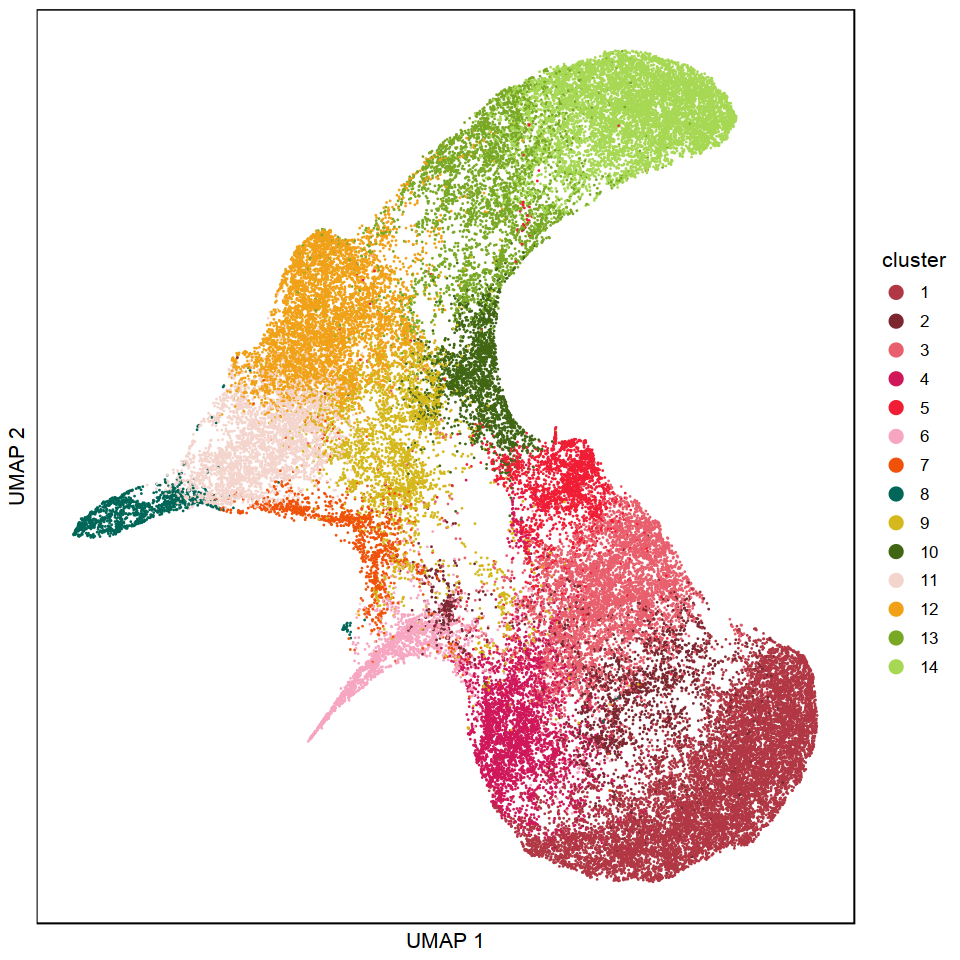

In [30]:
options(repr.plot.width = 8, repr.plot.height = 8)

plot_dimred(metaData$umap1,
           metaData$umap2,
           factor(metaData$cluster_new_id)) + 
scale_color_manual(values=as.character(cluster_config$colour)[order(cluster_config$new_cluster)]) +
guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4)))

### Genes Along Pseudotime

In [31]:
ATAC_SEL = which(metaData$cluster_new_id %in% c(1,7,11,12,13,14))

In [32]:
# RNA_SEL = atac2rna_nn$nn.idx[ATAC_SEL, 1]
RNA_SEL = atac2rna_same_cluster_nn[ATAC_SEL, 1]

In [33]:
atac.path.df <- data.frame(x = smooth.spline(metaData$umap1[ATAC_SEL][order(pseudotime[ATAC_SEL,"dpt_pseudotime"])], df=200, spar=.9)$y, 
                        y = smooth.spline(metaData$umap2[ATAC_SEL][order(pseudotime[ATAC_SEL,"dpt_pseudotime"])], df=200, spar=.9)$y)

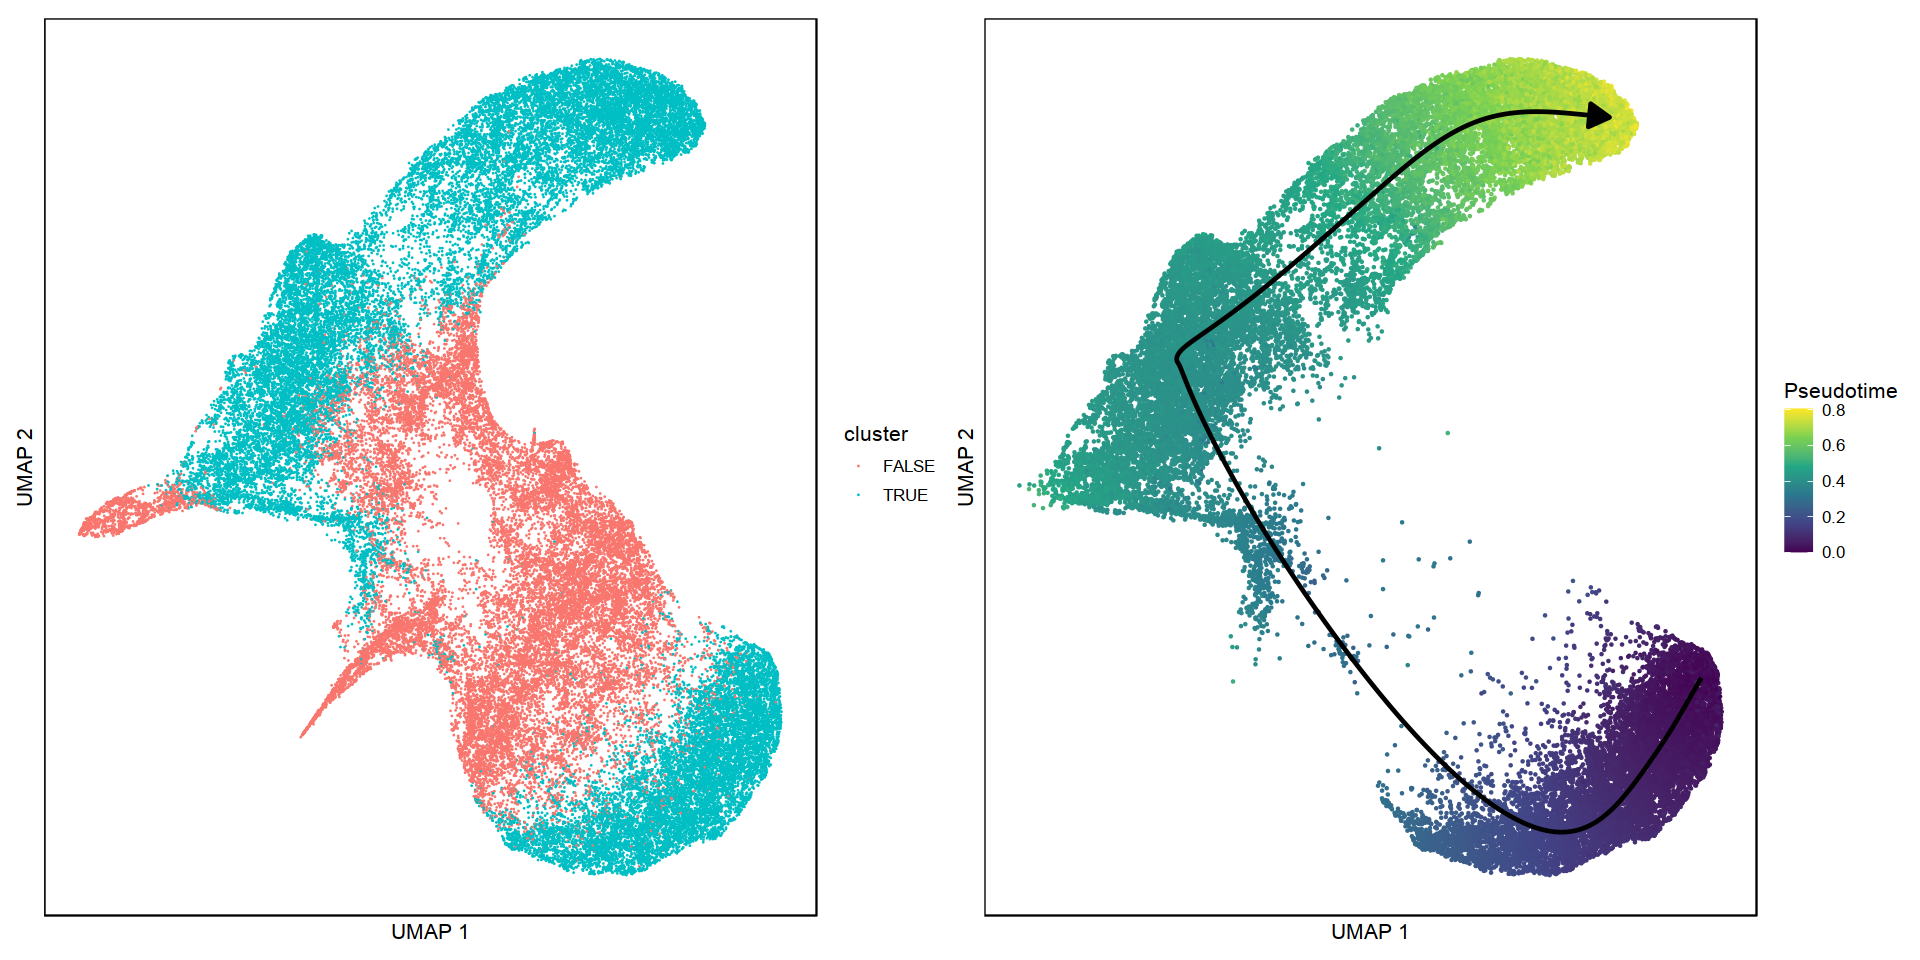

In [37]:
options(repr.plot.width = 16, repr.plot.height = 8)

(plot_dimred(metaData$umap1,
           metaData$umap2,
           seq(nrow(metaData)) %in% ATAC_SEL)) |
(plot_dimred(metaData$umap1[ATAC_SEL],
           metaData$umap2[ATAC_SEL],
           pseudotime[ATAC_SEL,"dpt_pseudotime"],
           sz=1) + 
scale_color_viridis_c(name="Pseudotime") +
geom_path(data=atac.path.df, 
          aes(x, y), 
          size=1,
          color="black", 
          arrow=arrow(type="closed",
                     length=unit(.03, "npc"))))

In [35]:
rna.path.df <- data.frame(x = smooth.spline(rna@reductions$umap@cell.embeddings[,1][RNA_SEL][order(pseudotime[ATAC_SEL,"dpt_pseudotime"])], 
                                            df=200, spar=.8)$y, 
                          y = smooth.spline(rna@reductions$umap@cell.embeddings[,2][RNA_SEL][order(pseudotime[ATAC_SEL,"dpt_pseudotime"])], 
                                            df=200, spar=.8)$y)

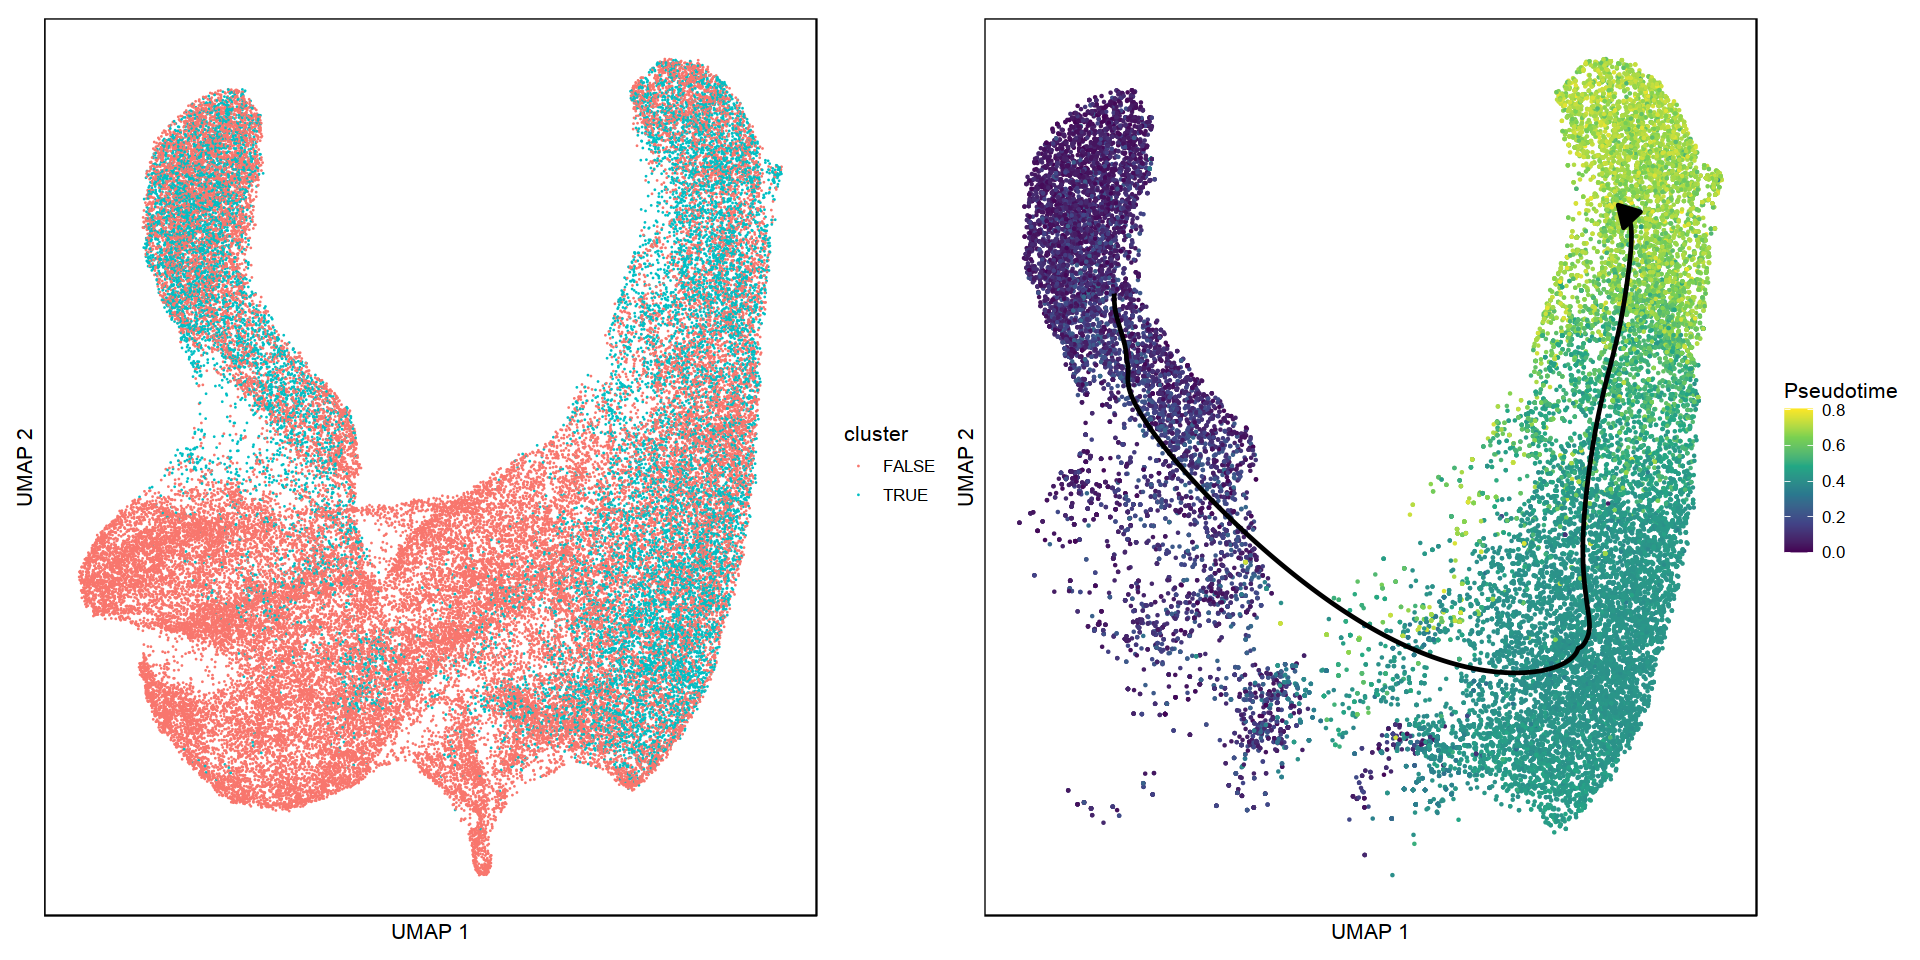

In [36]:
options(repr.plot.width = 16, repr.plot.height = 8)

(plot_dimred(rna@reductions$umap@cell.embeddings[,1],
           rna@reductions$umap@cell.embeddings[,2],
           seq(ncol(rna)) %in% RNA_SEL)) |
(plot_dimred(rna@reductions$umap@cell.embeddings[,1][RNA_SEL],
           rna@reductions$umap@cell.embeddings[,2][RNA_SEL],
           pseudotime[ATAC_SEL,"dpt_pseudotime"],
           sz=1)  + 
scale_color_viridis_c(name="Pseudotime") +
geom_path(data=rna.path.df, 
      aes(x, y), 
      size=1,
      color="black", 
      arrow=arrow(type="closed",
                 length=unit(.03, "npc"))))

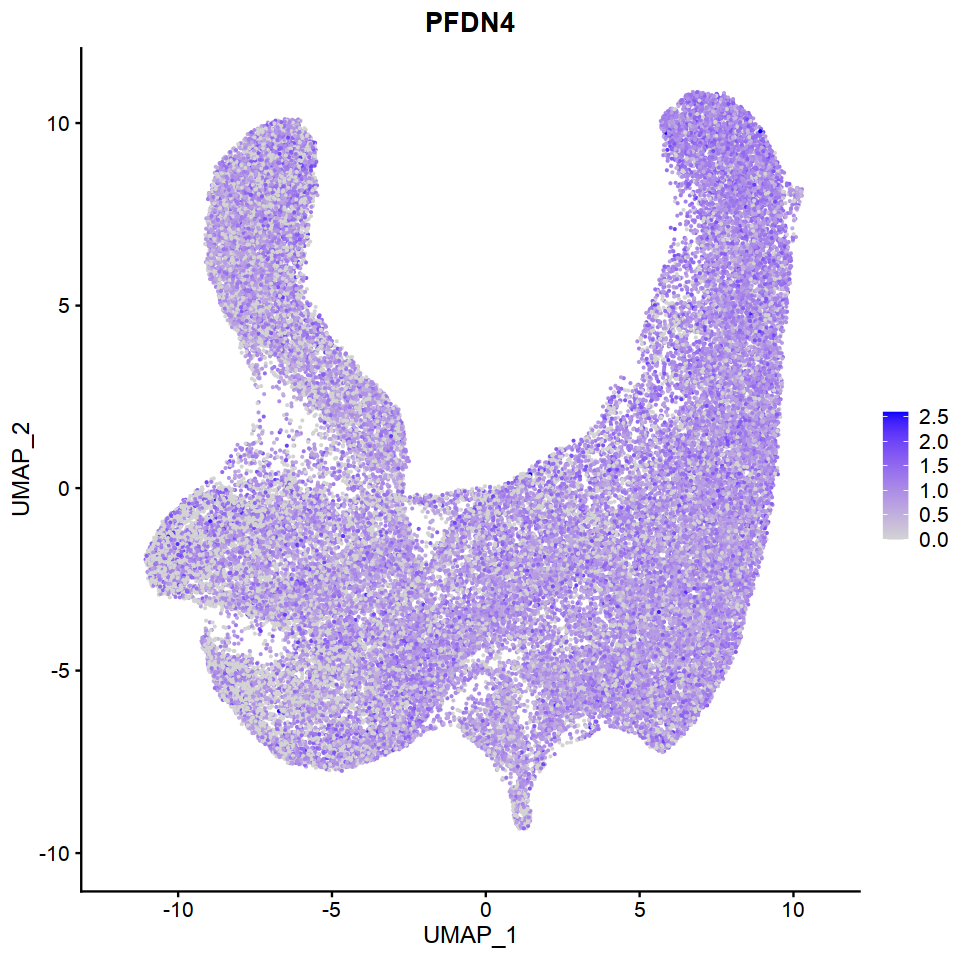

In [114]:
options(repr.plot.width = 8, repr.plot.height = 8)

FeaturePlot(rna, features = c("PFDN4"), reduction = "umap", pt.size = 0.1, combine = FALSE)[[1]]

## ChromVAR vs Expression Heatmaps

Sanity checks and linking motif genes to those with RNA.

In [62]:
all(colnames(chromvar) %in% rownames(motifs))

[1] TRUE

In [39]:
ncol(chromvar)

[1] 123

In [40]:
# motif archetypes represented
length(unique(motifs[colnames(chromvar), "Cluster_ID"]))
rev(sort(table(motif_archetypes[motifs[colnames(chromvar), "Cluster_ID"], "Name"])))

[1] 34


        AP1/1      KLF/SP/2          TEAD         RFX/1     OCT4+SOX2 
           12            11             6             6             6 
  Ebox/CAGCTG        ZNF143        RUNX/1         ETS/2          CTCF 
            6             5             5             5             5 
         NRF1           NFY           YY1       TFAP2/1         SIX/1 
            4             4             3             3             3 
    REST/NRSF      KLF/SP/1         KAISO      GC-tract         ETS/1 
            3             3             3             3             3 
   CREB/ATF/2         NFI/3         IRF/2         FOX/5         FOX/4 
            3             2             2             2             2 
 Ebox/CAGATGG Ebox/CACGTG/1    CREB/ATF/1    CCAAT/CEBP           ZFX 
            2             2             2             2             1 
        SOX/1         NFI/1        NFAC/2 Ebox/CACGTG/2 
            1             1             1             1 

In [41]:
rownames(rna)[grep("HOX1", rownames(rna))]

character(0)

In [42]:
# for each archetype, gather all genes present in archetype and look for matching
# genes in RNA expression
selected_archetypes = unique(motifs[colnames(chromvar), "Cluster_ID"])
selected_archetypes_names = motif_archetypes[selected_archetypes, "Name"]

# add missing genes manually
matching_genes_in_archetypes = list()
manually_added_genes_in_archetypes = list()
for (n in selected_archetypes_names) {
    matching_genes_in_archetypes[[n]] = c()
    manually_added_genes_in_archetypes[[n]] = c()
}

manually_added_genes_in_archetypes[["Ebox/CAGCTG"]] = c("BHLHA15", "TCF3") # TFE2 -> TCF3
manually_added_genes_in_archetypes[["CREB/ATF/1"]] = c("FOS", "FOSB", "FOSL1", "FOSL2", "JUN", "JUND")
manually_added_genes_in_archetypes[["AP1/1"]] = c("BATF", "NFE2L1") # for NF2L1
manually_added_genes_in_archetypes[["FOX/4"]] = c("AR") # AR for ANDR, FOXA2 not present in RNA
manually_added_genes_in_archetypes[["IRF/2"]] = c("BCL11A") # for BC11A
manually_added_genes_in_archetypes[["KLF/SP/2"]] = c("ZBTB17", "ZNF281")
manually_added_genes_in_archetypes[["GC-tract"]] = c("ZNF341", "ZNF467", "ZNF770", "ZSCAN22")
manually_added_genes_in_archetypes[["OCT4+SOX2"]] = c("POU3F1", "POU5F1")
manually_added_genes_in_archetypes[["NFI/1"]] = c() # TLX1 not present in RNA
manually_added_genes_in_archetypes[["NFY"]] = c("DUX4") # ortholog of mouse DUX
manually_added_genes_in_archetypes[["NFAC/2"]] = c("NFATC1") # for NFAC1
manually_added_genes_in_archetypes[["RUNX/1"]] = c("CBFB") # for PEBB
manually_added_genes_in_archetypes[["ZNF143"]] = c("THAP11", "ZNF143")
manually_added_genes_in_archetypes[["Ebox/CAGATGG"]] = c("NEUROD1", "NEUROD2", "NEUROG2", "TAL1", "TCF3", "TWIST1")

for (a in selected_archetypes) {
        arch_name  = motif_archetypes[a, "Name"]
        all_genes_in_archetypes = unique(toupper(motifs[motifs$Cluster_ID %in% a, "Gene"]))

        # only those with missing
        if (sum(!all_genes_in_archetypes %in% rownames(rna)) > 0) {
                cat(arch_name)
        cat("\n------\n")

        cat("Missing        : ")
        cat(sort(all_genes_in_archetypes[!all_genes_in_archetypes %in% rownames(rna)]))
        cat("\n")

        cat("Matching       : ")
        cat(sort(all_genes_in_archetypes[all_genes_in_archetypes %in% rownames(rna)]))
        cat("\n")

        cat("Manually added : ")
        cat(sort(manually_added_genes_in_archetypes[[arch_name]]))
        cat("\n\n")
    }
    
    matching_genes_in_archetypes[[arch_name]] = c(all_genes_in_archetypes[all_genes_in_archetypes %in% rownames(rna)],
                                                 manually_added_genes_in_archetypes[[arch_name]])
}

TFAP2/1
------
Missing        : AP2A AP2B AP2C TCFAP2A
Matching       : TFAP2A TFAP2B TFAP2C
Manually added : 

Ebox/CAGCTG
------
Missing        : BHA15 TFE2 ZBT18 ZNF238
Matching       : ASCL1 ASCL2 MSC MYF6 MYOD1 MYOG NHLH1 TCF12 TCF21 TFAP4 TWIST1 ZBTB18
Manually added : BHLHA15 TCF3

CREB/ATF/1
------
Missing        : FOS+JUN FOSB+JUN FOSB+JUNB FOSL1+JUN FOSL1+JUND FOSL2+JUN FOSL2+JUNB FOSL2+JUND JUN+JUNB
Matching       : ATF1 ATF2 ATF3 CREB1 CREM JUNB
Manually added : FOS FOSB FOSL1 FOSL2 JUN JUND

AP1/1
------
Missing        : BATF+JUN FOS+JUN FOS+JUNB FOS+JUND FOSB+JUNB FOSL1+JUN FOSL1+JUNB FOSL1+JUND FOSL2+JUN FOSL2+JUNB FOSL2+JUND JUN+JUNB NF2L1
Matching       : ATF3 FOS FOSB FOSL1 FOSL2 JDP2 JUN JUNB JUND NFE2
Manually added : BATF NFE2L1

FOX/4
------
Missing        : ANDR FOXA2
Matching       : FOXA1 FOXA3 FOXB1 FOXC1 FOXC2 FOXD3 FOXK1 FOXK2 FOXM1 FOXO1 FOXP1 FOXP2
Manually added : AR

IRF/2
------
Missing        : BC11A STAT1+STAT2
Matching       : IRF1 IRF2 IRF3 IRF4 IRF

Trajectory seleciton and plotting.

In [43]:
ATAC_SEL = which(metaData$cluster_new_id %in% c(1,7,11,12,13,14))

In [44]:
# RNA_SEL = atac2rna_nn$nn.idx[ATAC_SEL, 1]
RNA_SEL = atac2rna_same_cluster_nn[ATAC_SEL, 1]

In [45]:
all(rownames(metaData)[ATAC_SEL] %in% rownames(chromvar))
subset_atac_sel = ATAC_SEL[rownames(metaData)[ATAC_SEL] %in% rownames(chromvar)]

# subset_rna_sel = atac2rna_nn$nn.idx[subset_atac_sel, 1] # without same cluster NN constraint
subset_rna_sel = atac2rna_same_cluster_nn[subset_atac_sel, 1]
length(subset_atac_sel)

[1] TRUE

[1] 32447

In [46]:
cur_pseudotime = pseudotime[subset_atac_sel,"dpt_pseudotime"]

In [47]:
path_chromvar = t(chromvar[subset_atac_sel, ][order(cur_pseudotime), ])

In [48]:
path_expr = rna@assays$RNA@data[, subset_rna_sel][, order(cur_pseudotime)]

In [49]:
dim(path_chromvar)

[1]   123 32447

In [50]:
dim(path_expr)

[1] 27632 32447

In [190]:
# median day of every n cells along pseudotime
get_median_day_every_n <- function(days, n=100) {
    rounded_length = floor(length(days)/n)*n

    days_numeric = as.numeric(lapply(strsplit(as.character(days), "D"), "[[", 2))[1:rounded_length]

    averaged_days = colMedians(matrix(days_numeric, n))

    averaged_days = floor(averaged_days/2)*2 # when medians are odd

    averaged_days = paste("D", averaged_days, sep="")    
    
    averaged_days
}

In [191]:
ROUND_EVERY=100

In [192]:
atac_averaged_days = get_median_day_every_n(metaData[subset_atac_sel[order(pseudotime[subset_atac_sel,"dpt_pseudotime"])], "sample"], n=ROUND_EVERY)
rna_averaged_days = get_median_day_every_n(rna$sample[subset_rna_sel[order(pseudotime[subset_atac_sel,"dpt_pseudotime"])]], n=ROUND_EVERY)

In [193]:
table(atac_averaged_days)
table(rna_averaged_days)

atac_averaged_days
 D0 D10 D12 D14  D2  D4  D6  D8 
109   6   8  97  11   3  70  20 

rna_averaged_days
 D0 D10 D12 D14  D2  D4  D6  D8 
106  18  35  65   3   9  43  45 

In [53]:
SEL_ARCHETYPE = "YY1"

In [54]:
motifs_selected = rownames(path_chromvar)[motif_archetypes[motifs[rownames(path_chromvar), "Cluster_ID"], "Name"]==SEL_ARCHETYPE]

cor(t(path_chromvar[motifs_selected ,]))

TYY1_HUMAN.H11MO.0.A TYY1_MOUSE.H11MO.0.A YY1_MA0095.2
TYY1_HUMAN.H11MO.0.A 1.0000000            0.8461958            0.8234995   
TYY1_MOUSE.H11MO.0.A 0.8461958            1.0000000            0.7948257   
YY1_MA0095.2         0.8234995            0.7948257            1.0000000

In [55]:
gene_path_chromvarcor = cor(t(path_chromvar[motifs_selected ,]),
                       as.matrix(t(path_expr[matching_genes_in_archetypes[[SEL_ARCHETYPE]],])))
max(gene_x_motif_cor, na.rm=T)
min(gene_x_motif_cor, na.rm=T)
gene_x_motif_cor

[1] 0.3213266

[1] -0.0264593

ZFP42     YY1       YY2        
TYY1_HUMAN.H11MO.0.A 0.3213266 0.1170384 -0.02645930
TYY1_MOUSE.H11MO.0.A 0.3044893 0.1107027 -0.02140062
YY1_MA0095.2         0.2671083 0.1018797 -0.02012379

Within archetypes, remove highly correlated motifs.

In [63]:
WITHIN_ARCH_CORR_CUTOFF = 0.2

In [64]:
selected_archetypes = unique(motifs[colnames(chromvar), "Cluster_ID"])
motifs_corr_filtered = list()

for (a in selected_archetypes) {
    arch_name = motif_archetypes[a, "Name"]
    cur_motifs = rownames(path_chromvar)[motifs[rownames(path_chromvar), "Cluster_ID"] == a]
    
    
    if (length(cur_motifs) == 1) {
        motifs_corr_filtered[[arch_name]] = cur_motifs
    }
    
    else {
        corrs = cor(t(path_chromvar[cur_motifs, ]))
        
        # bring those that are correlated with most others to the top
        corrs = corrs[rev(order(rowSums(corrs))), rev(order(rowSums(corrs)))]
        
        # select top one by default
        cur_selected = c(1)
        
        # check others against the ones selected
        for (i in seq(2, nrow(corrs))) {
            is_cor_with_selected = FALSE
            for (j in cur_selected) {
                if (corrs[i, j] > WITHIN_ARCH_CORR_CUTOFF) {
                    is_cor_with_selected = TRUE
                    break
                }
            }
            
            if (is_cor_with_selected == FALSE) {
                cur_selected = c(cur_selected, i)
            }
        }
        
        motifs_corr_filtered[[arch_name]] = rownames(corrs)[cur_selected]
          
        # sanity check max correlation between selected TFs chromvars
#         if (length(motifs_corr_filtered[[arch_name]]) > 1 ) {
#             corr_among_selected = cor(t(path_chromvar[motifs_corr_filtered[[arch_name]], ]))
#             diag(corr_among_selected) = 0
#             print(max(corr_among_selected))
#         }
    }
} 

In [65]:
length(unlist(motifs_corr_filtered))

[1] 36

In [66]:
motifs_corr_filtered

$`TFAP2/1`
[1] "AP2C_HUMAN.H11MO.0.A"

$`Ebox/CAGCTG`
[1] "ZNF238_C2H2_2"

$`CREB/ATF/1`
[1] "CREB1_MA0018.3"       "ATF1_MOUSE.H11MO.0.B"

$`AP1/1`
[1] "FOS+JUND_MA1141.1"

$`CCAAT/CEBP`
[1] "CEBPB_MOUSE.H11MO.0.A"

$`CREB/ATF/2`
[1] "JDP2_MA0656.1"

$CTCF
[1] "CTCF_HUMAN.H11MO.0.A"

$`ETS/1`
[1] "ELK4_MA0076.2"

$`ETS/2`
[1] "ETS1_MOUSE.H11MO.0.A"

$`FOX/5`
[1] "FOXL2_MOUSE.H11MO.0.C"

$`FOX/4`
[1] "FOXC2_MA0846.1"

$`IRF/2`
[1] "IRF1_MOUSE.H11MO.0.A"

$KAISO
[1] "KAISO_MOUSE.H11MO.0.B"

$`KLF/SP/1`
[1] "Klf1_MA0493.1"

$`KLF/SP/2`
[1] "SP3_MOUSE.H11MO.0.B"

$`GC-tract`
[1] "TAF1_HUMAN.H11MO.0.A"

$`Ebox/CACGTG/2`
[1] "MYC_HUMAN.H11MO.0.A"

$`OCT4+SOX2`
[1] "NANOG_HUMAN.H11MO.0.A"

$`NFI/3`
[1] "NFIC_HUMAN.H11MO.0.A"

$`NFI/1`
[1] "NFIB_MOUSE.H11MO.0.C"

$NFY
[1] "NFYB_MOUSE.H11MO.0.A"

$NRF1
[1] "NRF1_HUMAN.H11MO.0.A"

$`NFAC/2`
[1] "PRDM6_HUMAN.H11MO.0.C"

$`REST/NRSF`
[1] "REST_MA0138.2"

$`RFX/1`
[1] "RFX1_MOUSE.H11MO.0.A" "RFX2_HUMAN.H11MO.0.A"

$`RUNX/1`
[1] "RUNX1_MOUSE.H11MO.0.A"

$`SIX/1`
[1] "SIX2_MOUSE.H11MO.0.A"

$`SOX/1`
[1] "Sox3_MA0514.1"

$TEAD
[1] "TEAD4_HUMAN.H11MO.0.A"

$ZNF143
[1] "ZN143_HUMAN.H11MO.0.A"

$`Ebox/CAGATGG`
[1] "TWST1_MOUSE.H11MO.0.B"

$YY1
[1] "TYY1_HUMAN.H11MO.0.A"

$`Ebox/CACGTG/1`
[1] "USF2_MOUSE.H11MO.0.A"

$ZFX
[1] "ZFX_MOUSE.H11MO.0.B"

In [67]:
motifs_corr_filtered_unlisted = unlist(motifs_corr_filtered)
names(motifs_corr_filtered_unlisted) = NULL

Remove motifs that don't correlate well with pseudotime.

In [68]:
PSEUDOTIME_CORR_CUTOFF = 0.2

In [70]:
cv_corr_pst = apply(path_chromvar[motifs_corr_filtered_unlisted, ], 1,
                    function(x) {cor(x, seq(1,length(x)))})
head(sort(abs(cv_corr_pst)))

ATF1_MOUSE.H11MO.0.B SIX2_MOUSE.H11MO.0.A IRF1_MOUSE.H11MO.0.A 
         0.002076297          0.044139273          0.052262184 
RFX2_HUMAN.H11MO.0.A  MYC_HUMAN.H11MO.0.A USF2_MOUSE.H11MO.0.A 
         0.114966370          0.172023660          0.225966359

In [71]:
motifs_corr_filtered_unlisted = motifs_corr_filtered_unlisted[abs(cv_corr_pst)>PSEUDOTIME_CORR_CUTOFF]

In [72]:
length(motifs_corr_filtered_unlisted)

[1] 31

Expression matches for each selected motif, from within genes linked to its archetypes.

In [73]:
linked_genes = c()
linked_gene_corrs = c()

for (m in motifs_corr_filtered_unlisted) {
    cur_motif_arch = motif_archetypes[motifs[m, "Cluster_ID"], "Name"]
    
    if (length(matching_genes_in_archetypes[[cur_motif_arch]]) == 1) {
        linked_genes = c(linked_genes, matching_genes_in_archetypes[[cur_motif_arch]][1])
        linked_gene_corrs = c(linked_gene_corrs,
                            cor(unlist(path_expr[matching_genes_in_archetypes[[cur_motif_arch]][1], ]),
                               path_chromvar[m, ]))
    }
    
    else {
        # pick one with highest correlation
        corrs = cor(t(as.matrix(path_expr[matching_genes_in_archetypes[[cur_motif_arch]], ])),
                   path_chromvar[m, ])
        
        max_idx = which.max(corrs)
        
        linked_genes = c(linked_genes, rownames(corrs)[max_idx])
        linked_gene_corrs = c(linked_gene_corrs,
                             corrs[max_idx])
        
    }
}

names(linked_genes) = motifs_corr_filtered_unlisted
names(linked_gene_corrs) = motifs_corr_filtered_unlisted

Warning message in cor(t(as.matrix(path_expr[matching_genes_in_archetypes[[cur_motif_arch]], :
“the standard deviation is zero”
Warning message in cor(t(as.matrix(path_expr[matching_genes_in_archetypes[[cur_motif_arch]], :
“the standard deviation is zero”


In [74]:
length(unique(linked_genes))

[1] 29

In [75]:
rev(sort(table(linked_genes)))

linked_genes
  NFIC   ETV4 ZNF770 ZNF143    ZFX  ZFP42 ZBTB33 TWIST1 TFAP2C  TEAD1  TCF21 
     2      2      1      1      1      1      1      1      1      1      1 
  SOX2  SALL4  RUNX1   RFX5   REST POU5F1   NRF1   NFYB NFATC1   KLF4   JUNB 
     1      1      1      1      1      1      1      1      1      1      1 
   JUN   HEY2  FOXF2  FOXC2    FOS  CTCFL  CEBPD 
     1      1      1      1      1      1      1 

In [76]:
linked_genes

AP2C_HUMAN.H11MO.0.A         ZNF238_C2H2_2        CREB1_MA0018.3 
             "TFAP2C"               "TCF21"                 "FOS" 
    FOS+JUND_MA1141.1 CEBPB_MOUSE.H11MO.0.A         JDP2_MA0656.1 
               "JUNB"               "CEBPD"                 "JUN" 
 CTCF_HUMAN.H11MO.0.A         ELK4_MA0076.2  ETS1_MOUSE.H11MO.0.A 
              "CTCFL"                "ETV4"                "ETV4" 
FOXL2_MOUSE.H11MO.0.C        FOXC2_MA0846.1 KAISO_MOUSE.H11MO.0.B 
              "FOXF2"               "FOXC2"              "ZBTB33" 
        Klf1_MA0493.1   SP3_MOUSE.H11MO.0.B  TAF1_HUMAN.H11MO.0.A 
               "KLF4"               "SALL4"              "ZNF770" 
NANOG_HUMAN.H11MO.0.A  NFIC_HUMAN.H11MO.0.A  NFIB_MOUSE.H11MO.0.C 
             "POU5F1"                "NFIC"                "NFIC" 
 NFYB_MOUSE.H11MO.0.A  NRF1_HUMAN.H11MO.0.A PRDM6_HUMAN.H11MO.0.C 
               "NFYB"                "NRF1"              "NFATC1" 
        REST_MA0138.2  RFX1_MOUSE.H11MO.0.A RUNX1_MOUSE.H11MO.0.A 
               "REST"                "RFX5"               "RUNX1" 
        Sox3_MA0514.1 TEAD4_HUMAN.H11MO.0.A ZN143_HUMAN.H11MO.0.A 
               "SOX2"               "TEAD1"              "ZNF143" 
TWST1_MOUSE.H11MO.0.B  TYY1_HUMAN.H11MO.0.A  USF2_MOUSE.H11MO.0.A 
             "TWIST1"               "ZFP42"                "HEY2" 
  ZFX_MOUSE.H11MO.0.B 
                "ZFX"

In [77]:
# motifs correlated with manually added genes
linked_genes[linked_genes %in% unlist(manually_added_genes_in_archetypes)]

CREB1_MA0018.3         JDP2_MA0656.1  TAF1_HUMAN.H11MO.0.A 
                "FOS"                 "JUN"              "ZNF770" 
NANOG_HUMAN.H11MO.0.A PRDM6_HUMAN.H11MO.0.C ZN143_HUMAN.H11MO.0.A 
             "POU5F1"              "NFATC1"              "ZNF143" 
TWST1_MOUSE.H11MO.0.B 
             "TWIST1"

In [78]:
minmax_normalize <- function(x)
{
    x = ((x- quantile(x, 0.02)) /(quantile(x, 0.98)-quantile(x, 0.02)))
    x[x<0] = 0
    x[x>1] = 1
    x
}

In [79]:
path_filtered_minmax_chromvar = t(apply(path_chromvar[motifs_corr_filtered_unlisted, ], 
                                        1, minmax_normalize))

In [80]:
path_filtered_minmax_expr = t(apply(path_expr[linked_genes, ], 
                                        1, minmax_normalize))

In [81]:
average_pseudotime <- function(x) {
    return (sum(x*seq(1,length(x)))/sum(x))
}

In [82]:
# calculate average pseudotime weighted by chromvar
avg_pst = apply(path_filtered_minmax_chromvar, 1, average_pseudotime)            

In [83]:
cv_dist = dist(path_filtered_minmax_chromvar)
cluster = hclust(cv_dist, method="complete")
dendrogram = as.dendrogram(cluster)
    
# reorder based on average pseudotime of motifs
dendrogram = reorder(dendrogram, avg_pst, mean)

In [84]:
rownames(path_filtered_minmax_chromvar)[order.dendrogram(dendrogram)]

[1] "FOS+JUND_MA1141.1"     "RUNX1_MOUSE.H11MO.0.A" "FOXL2_MOUSE.H11MO.0.C"
 [4] "FOXC2_MA0846.1"        "CEBPB_MOUSE.H11MO.0.A" "JDP2_MA0656.1"        
 [7] "CREB1_MA0018.3"        "ZNF238_C2H2_2"         "TWST1_MOUSE.H11MO.0.B"
[10] "TEAD4_HUMAN.H11MO.0.A" "NFIB_MOUSE.H11MO.0.C"  "NFIC_HUMAN.H11MO.0.A" 
[13] "PRDM6_HUMAN.H11MO.0.C" "USF2_MOUSE.H11MO.0.A"  "KAISO_MOUSE.H11MO.0.B"
[16] "REST_MA0138.2"         "NRF1_HUMAN.H11MO.0.A"  "TYY1_HUMAN.H11MO.0.A" 
[19] "NFYB_MOUSE.H11MO.0.A"  "ELK4_MA0076.2"         "ETS1_MOUSE.H11MO.0.A" 
[22] "ZN143_HUMAN.H11MO.0.A" "RFX1_MOUSE.H11MO.0.A"  "CTCF_HUMAN.H11MO.0.A" 
[25] "TAF1_HUMAN.H11MO.0.A"  "ZFX_MOUSE.H11MO.0.B"   "AP2C_HUMAN.H11MO.0.A" 
[28] "Sox3_MA0514.1"         "Klf1_MA0493.1"         "NANOG_HUMAN.H11MO.0.A"
[31] "SP3_MOUSE.H11MO.0.B"

In [85]:
path_chromvar_to_plot = path_filtered_minmax_chromvar[order.dendrogram(dendrogram), ]
rownames(path_chromvar_to_plot) = paste(rownames(path_chromvar_to_plot),
                                       motif_archetypes[motifs[rownames(path_chromvar_to_plot), "Cluster_ID"], "Name"],
                                       sep=' - ')
head(path_chromvar_to_plot, 2)

D0_AACGCGAGAAGGACCA D0_CCTTGGTACTAGACAA
FOS+JUND_MA1141.1 - AP1/1      0.6253629           0.4838821          
RUNX1_MOUSE.H11MO.0.A - RUNX/1 0.7659250           0.5280012          
                               D0_CAAGAGTCTAGTGAGC D0_GATCGCGTGACGAGCA
FOS+JUND_MA1141.1 - AP1/1      0.5881980           0.6865184          
RUNX1_MOUSE.H11MO.0.A - RUNX/1 0.5527709           0.7137009          
                               D0_AACGCGAGATTGCGCG D0_TACCCGTTGTGCGGCT
FOS+JUND_MA1141.1 - AP1/1      0.6539814           0.6090240          
RUNX1_MOUSE.H11MO.0.A - RUNX/1 0.7789541           0.8720451          
                               D0_GGACACCTGACAGGTG D0_TCGCGGAACTACTTTC
FOS+JUND_MA1141.1 - AP1/1      0.7202345           0.6360718          
RUNX1_MOUSE.H11MO.0.A - RUNX/1 0.7485600           0.6223837          
                               D0_CAGCCGATGTTATGGC D0_TTCCCTGGAGGGATTG ⋯
FOS+JUND_MA1141.1 - AP1/1      0.5194455           0.6012004           ⋯
RUNX1_MOUSE.H11MO.0.A - RUNX/1 0.5533114           0.6910039           ⋯
                               D14_CATTCTATGACAGGTG D14_GCACAATACATCATGC
FOS+JUND_MA1141.1 - AP1/1      0.22016910           0.1351829           
RUNX1_MOUSE.H11MO.0.A - RUNX/1 0.01364443           0.1210637           
                               D14_TCACCCATGCAGATTC D14_TCCGTTGTGTCCAATG
FOS+JUND_MA1141.1 - AP1/1      0.09434372           0.2323425           
RUNX1_MOUSE.H11MO.0.A - RUNX/1 0.14258409           0.1206315           
                               D14_CGTACAAACACGCGAA D14_CTTGCGGGAAAATGCA
FOS+JUND_MA1141.1 - AP1/1      0.3205043            0.1433444           
RUNX1_MOUSE.H11MO.0.A - RUNX/1 0.5464664            0.3818129           
                               D14_GGCACAAGACATACTG D14_GGTGTAACTGTTAGTC
FOS+JUND_MA1141.1 - AP1/1      0.1600673            0.1478570           
RUNX1_MOUSE.H11MO.0.A - RUNX/1 0.5958062            0.2942606           
                               D14_ATAGGGTCTCGGTTTA D14_GGTTGGAGATGCTCAA
FOS+JUND_MA1141.1 - AP1/1      0.09361776           0.2189942           
RUNX1_MOUSE.H11MO.0.A - RUNX/1 0.51840446           0.6795121

In [86]:
library(viridis)
library(scales)

Loading required package: viridisLite


Attaching package: ‘scales’


The following object is masked from ‘package:viridis’:

    viridis_pal




In [87]:
quantile(path_chromvar_to_plot, c(0.05, .95))

5%        95% 
0.05830693 0.89082825

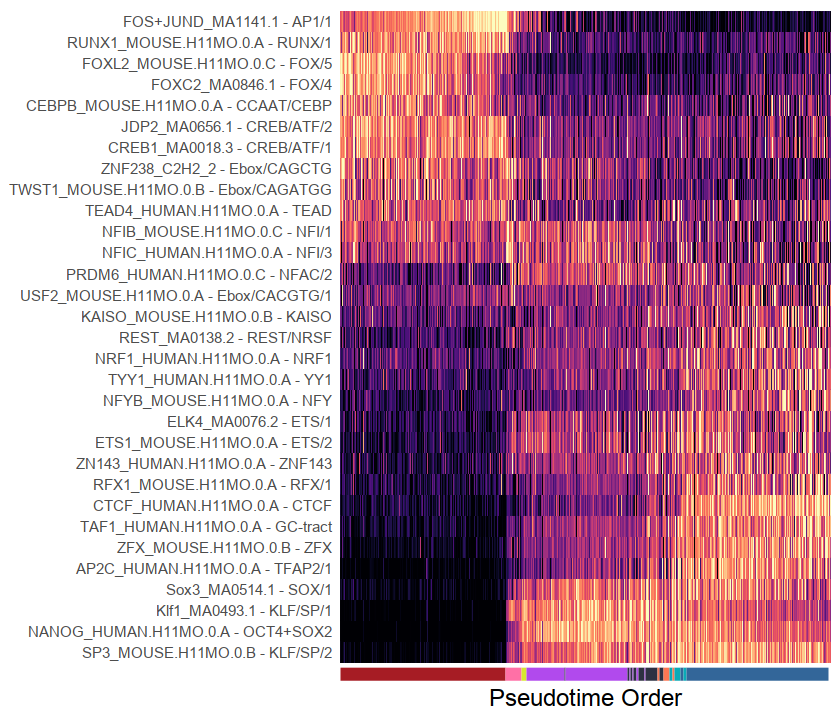

In [436]:
options(repr.plot.width = 7, repr.plot.height = 6)

SUBSAMPLE=10
idxs = seq(1, ncol(path_chromvar_to_plot), SUBSAMPLE) # if subsample
melted_df_to_plot = reshape2::melt(path_chromvar_to_plot[, idxs])

motif_heatmap <- ggplot(data = melted_df_to_plot, 
           mapping = aes(x = Var2,
                         y = factor(Var1, 
                                    levels=rev(levels(Var1))),
                         fill = value)) +
    geom_tile()  + ylab(NULL) + xlab("Pseudotime Order") +  
    geom_raster(aes(fill=value)) +
    scale_fill_viridis(limits=c(0.1, .95), 
                       oob=squish, 
                       option = "A",
                      name="ChromVAR") +
    # scale_fill_viridis(option="A") + 
    # scale_fill_gradient2(low="red", mid="black", high="blue") 
    # theme_classic() +
    theme(axis.text.x=element_blank(),
          axis.title.x=element_text(size=14),
          axis.ticks.x=element_blank(),
    #       axis.text.y=element_blank(),
          axis.ticks.y=element_blank(),
         legend.position="none")

# add pseudotime order days
i=1
for (j in seq(1,length(atac_averaged_days))) {
    if ((atac_averaged_days[i] != atac_averaged_days[j]) || (j==length(atac_averaged_days))) {
        
        motif_heatmap = motif_heatmap + annotate("segment", 
                                                     x=((i-1)*ROUND_EVERY+1)/SUBSAMPLE, 
                                                     xend=((j-1)*ROUND_EVERY)/SUBSAMPLE,
                                             y= -0.3, yend= -0.3, size=5,
                                             color=day_config[atac_averaged_days[i], "colour"])
        i=j
        
    }

}

motif_heatmap

In [293]:
path_expr_to_plot = path_filtered_minmax_expr[order.dendrogram(dendrogram), ]
rnames = rownames(path_expr_to_plot)
rownames(path_expr_to_plot) = seq(1,nrow(path_expr_to_plot)) # genes may be repeated hence need to use unique
colnames(path_expr_to_plot) = seq(ncol(path_expr_to_plot)) # barcodes may also be repeated hence need to use unique
head(path_expr_to_plot, 2)

1 2         3         4         5         6         7         8        
1 1 0.8828423 0.6691199 0.0000000 0.7687183 0.4722349 0.3248399 0.7083401
2 0 0.0000000 0.0000000 0.4737236 0.0000000 0.5533602 0.2690939 0.0000000
  9         10        ⋯ 32438 32439 32440 32441 32442    32443 32444    32445
1 0.0000000 0.4892174 ⋯ 0     0     0     0     0.272843 0     0.331876 0    
2 0.3719367 0.3295967 ⋯ 0     0     0     0     0.000000 0     0.000000 0    
  32446     32447
1 0.2540917 0    
2 0.0000000 0

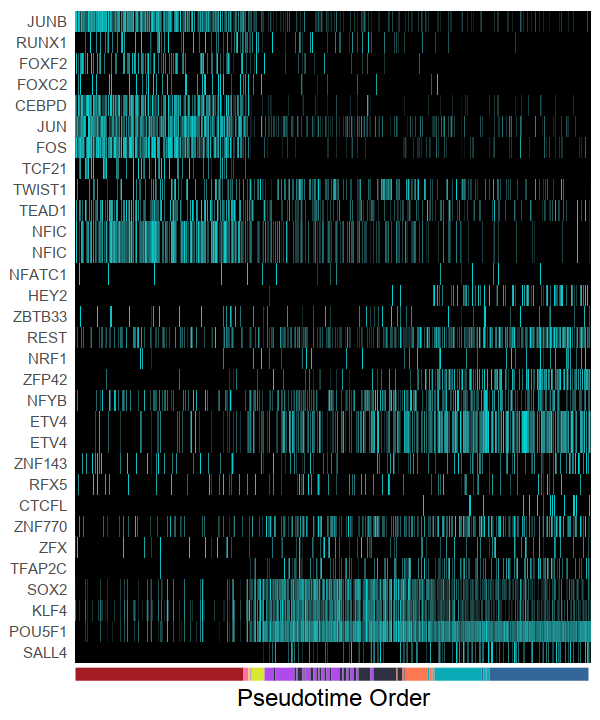

In [437]:
options(repr.plot.width = 5, repr.plot.height = 6)

SUBSAMPLE=10
idxs = seq(1, ncol(path_expr_to_plot), SUBSAMPLE) # if subsample
melted_df_to_plot = reshape2::melt(path_expr_to_plot[, idxs])
expr_heatmap <- ggplot(data = melted_df_to_plot, 
           mapping = aes(x = factor(Var2),
                         y = factor(rev(Var1)), 
                         fill = value)) +
    geom_tile()  + ylab(NULL) + xlab("Pseudotime Order") +  
    scale_y_discrete(labels=rev(rnames)) + 
    geom_raster(aes(fill=value)) + 
    # scale_fill_viridis(limits=c(0, 1), oob=squish, option = "C") +
    # scale_fill_viridis(option="A") + 
    scale_fill_gradient(limits=c(0,1), 
                        low="black", 
                        high="darkturquoise",
                       name="Expression") +
    # theme_classic() +
    theme(axis.text.x=element_blank(),
          axis.title.x=element_text(size=14),
          axis.ticks.x=element_blank(),
    #       axis.text.y=element_blank(),
          axis.ticks.y=element_blank(),
         legend.position="none")

# add pseudotime order days
i=1
for (j in seq(1,length(rna_averaged_days))) {
    if ((rna_averaged_days[i] != rna_averaged_days[j]) || (j==length(rna_averaged_days))) {
        
        expr_heatmap = expr_heatmap + annotate("segment", 
                                             x=((i-1)*ROUND_EVERY+1)/SUBSAMPLE, 
                                             xend=((j-1)*ROUND_EVERY)/SUBSAMPLE,
                                             y= -0.3, yend= -0.3, size=5,
                                             color=day_config[rna_averaged_days[i], "colour"])
        i=j
    }

}

expr_heatmap

In [438]:
head(data.frame(linked_gene_corrs))

linked_gene_corrs
AP2C_HUMAN.H11MO.0.A  0.4057504        
ZNF238_C2H2_2         0.1963165        
CREB1_MA0018.3        0.4325865        
FOS+JUND_MA1141.1     0.5988614        
CEBPB_MOUSE.H11MO.0.A 0.4530006        
JDP2_MA0656.1         0.4060418

In [486]:
linked_gene_corrs

AP2C_HUMAN.H11MO.0.A         ZNF238_C2H2_2        CREB1_MA0018.3 
          0.405750397           0.196316500           0.432586456 
    FOS+JUND_MA1141.1 CEBPB_MOUSE.H11MO.0.A         JDP2_MA0656.1 
          0.598861396           0.453000606           0.406041783 
 CTCF_HUMAN.H11MO.0.A         ELK4_MA0076.2  ETS1_MOUSE.H11MO.0.A 
          0.165397749           0.356124026           0.372620819 
FOXL2_MOUSE.H11MO.0.C        FOXC2_MA0846.1 KAISO_MOUSE.H11MO.0.B 
          0.381104212           0.175062831           0.005990299 
        Klf1_MA0493.1   SP3_MOUSE.H11MO.0.B  TAF1_HUMAN.H11MO.0.A 
          0.441790729           0.350231667           0.276298678 
NANOG_HUMAN.H11MO.0.A  NFIC_HUMAN.H11MO.0.A  NFIB_MOUSE.H11MO.0.C 
          0.770988828           0.106491104           0.178137685 
 NFYB_MOUSE.H11MO.0.A  NRF1_HUMAN.H11MO.0.A PRDM6_HUMAN.H11MO.0.C 
          0.112578486           0.036800352          -0.011217345 
        REST_MA0138.2  RFX1_MOUSE.H11MO.0.A RUNX1_MOUSE.H11MO.0.A 
          0.208131660           0.030130256           0.221528707 
        Sox3_MA0514.1 TEAD4_HUMAN.H11MO.0.A ZN143_HUMAN.H11MO.0.A 
          0.433137598           0.138156649           0.056063972 
TWST1_MOUSE.H11MO.0.B  TYY1_HUMAN.H11MO.0.A  USF2_MOUSE.H11MO.0.A 
          0.074617540           0.321326619           0.104239600 
  ZFX_MOUSE.H11MO.0.B 
         -0.037277738

In [439]:
linked_gene_corrs_ordered_df = data.frame(linked_gene_corrs[order.dendrogram(dendrogram)])
colnames(linked_gene_corrs_ordered_df) = c("corr")
linked_gene_corrs_ordered_df$motif = factor(rownames(linked_gene_corrs_ordered_df) , levels=rev(rownames(linked_gene_corrs_ordered_df)))

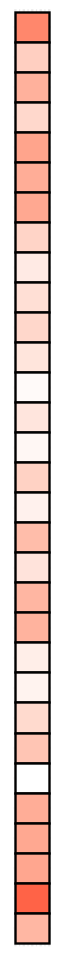

In [478]:
options(repr.plot.width = .5, repr.plot.height = 8)

corr_plot <- ggplot(linked_gene_corrs_ordered_df) + 
geom_tile(aes(x=1, y=motif, fill=corr),
         color="black", size=0.5) +
theme_minimal() +
# ylab("Correlation") +
scale_fill_gradient(low="white", high="tomato",name="ChromVAR-Expression\nCorrelation") +
theme(axis.text.y=element_blank(),
      axis.text.x=element_blank(),
      axis.title.x = element_blank(),
      axis.title.y = element_blank(),
     legend.position="none")

corr_plot

In [479]:
motif_legend = cowplot::get_legend(motif_heatmap+theme(legend.position="bottom") + 
                                   guides(fill = guide_colourbar(title.position = "top",
                                                             title.hjust=0.5)))
expr_legend = cowplot::get_legend(expr_heatmap+theme(legend.position="bottom") + 
                                   guides(fill = guide_colourbar(title.position = "top",
                                                             title.hjust=0.5)))
corr_legend = cowplot::get_legend(corr_plot+theme(legend.position="bottom") + 
                                   guides(fill = guide_colourbar(title.position = "top",
                                                             title.hjust=0.5)))

In [480]:
days_legend = cowplot::get_legend(ggplot(day_config) +
                                geom_tile(aes(x=day,y=1, fill=factor(day, levels=day))) +
                                scale_fill_manual(values = day_config$colour, name="Day") + 
                                theme(legend.position="bottom", legend.box="horizontal") +
                                guides(fill = guide_legend(nrow = 1, 
                                                           title.position="top",
                                                          title.hjust=0.5)))

In [481]:
legends = wrap_plots(plot_spacer(), 
                     motif_legend, 
                     expr_legend, 
                     corr_legend,
                     plot_spacer(),
                     days_legend,
                     plot_spacer(),
                     widths=c(0.5,1,1,1,1,2,.5))

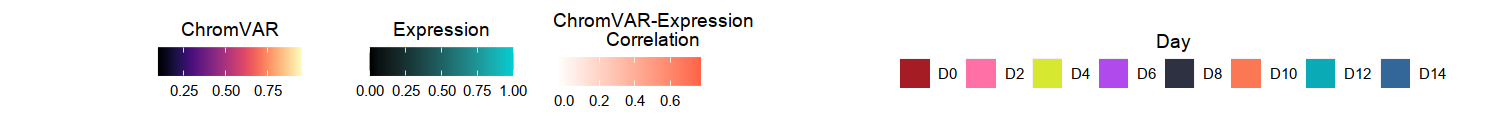

In [482]:
options(repr.plot.width = 12.5, repr.plot.height = 1)

legends

In [483]:
combined <- wrap_plots(plot_spacer(),
                       motif_heatmap,
                       expr_heatmap,
                       plot_spacer(),
                       wrap_plots(corr_plot,
                                  plot_spacer(),
                                  heights=c(1,-0.001)), # tune this to align corr bar
                       widths=c(0,6,6,0, .5))

In [484]:
combined_with_legends = wrap_plots(combined,                            
                                  legends,
                                  heights=c(8,1))

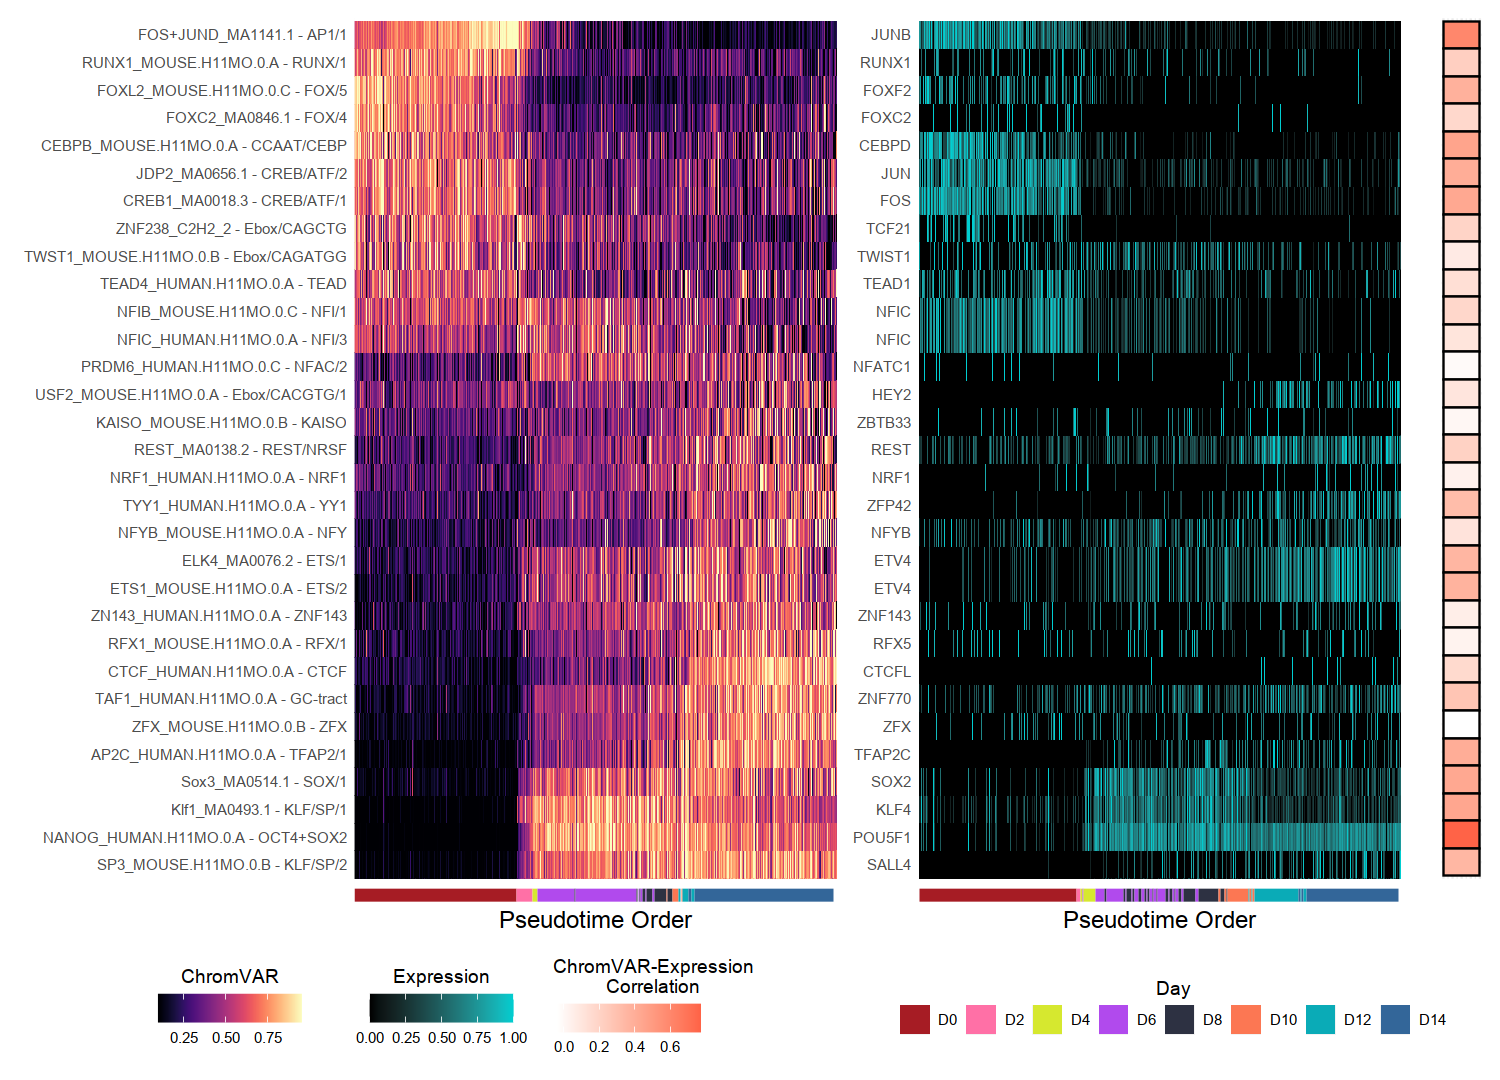

In [485]:
options(repr.plot.width = 12.5, repr.plot.height = 9)

combined_with_legends

---

In [ ]:
sessionInfo()